In [ ]:
%%HTML
<style> code {background-color : pink !important;} </style>

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
import pickle
%matplotlib qt

In [3]:
def calCamera(cal_img_dir, board_shape=(9,6)):
    obj_pnt = np.zeros((board_shape[0]*board_shape[1],3), np.float32)
    obj_pnt[:,:2] = np.mgrid[0:board_shape[0], 0:board_shape[1]].T.reshape(-1,2 )
    images = glob.glob(cal_img_dir)
    obj_pnts = []
    img_pnts = []
    img_size = None
    for idx, fname in enumerate(images):
        img = cv2.imread(fname) 
        if (img_size == None):
            img_size = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, board_shape, None)
        if ret == True:
            obj_pnts.append(obj_pnt)
            img_pnts.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pnts, img_pnts, img_size,None,None)
    return (mtx, dist)


In [4]:
mtx, dist = calCamera("camera_cal/calibration*.jpg")
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "cal_pickle.p", "wb" ))

In [5]:
cal_pickle = pickle.load(open( "cal_pickle.p", "rb" ))
mtx = cal_pickle["mtx"]
dist = cal_pickle["dist"]

In [7]:
from collections import deque
def sanityCheck(left_fit, right_fit, y_range=(0,720)):
    if left_fit is None or right_fit is None:
        return False
    ploty = np.linspace(y_range[0], y_range[1], (y_range[1]-y_range[0])//50)
    x_left = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]

    left_slope = -1/(2*left_fit[0]*ploty + left_fit[1])
    dist_points = []
    for idx in range(len(ploty)):
        y_x_right = findIntersec(np.array([0,left_slope[idx],x_left[idx]-left_slope[idx]*ploty[idx]]), right_fit)
        for inters in y_x_right:
            if 0<inters[0]<720:
                
                dist_points.append([x_left[idx], ploty[idx], inters[1], inters[0]])
    
    dist_points = np.array(dist_points)
    distances = np.sqrt((dist_points[:,0] - dist_points[:,2])**2+(dist_points[:,1] - dist_points[:,3])**2)
    dis_std = np.std(distances)
    if dis_std>50:
        return False
    return True
def findIntersec(poly1, poly2):
    poly_gen1 = np.polynomial.polynomial.Polynomial(poly1[::-1])
    poly_gen2 = np.polynomial.polynomial.Polynomial(poly2[::-1])
    roots = np.polynomial.polynomial.polyroots(poly1[::-1] - poly2[::-1])
    ret = []
    for root in roots:
        ret.append([root,poly_gen1(root)])
    return ret
class Lines:
    def __init__(self, queue_size=5):
        self._line_queue = deque()
        self._queue_size = queue_size
        self._bad_frame_count = 0
    def addLine(self, l_r_fit):
        if (sanityCheck(*l_r_fit)):
            self._bad_frame_count = 0
            self._line_queue.append(l_r_fit)
            if len(self._line_queue)>self._queue_size:
                self._line_queue.popleft() 
        else:
            self._bad_frame_count+=1
    def avgLine(self):
        if len(self._line_queue)!=0 and self._bad_frame_count<10:
            ret_fit = np.mean(np.array(self._line_queue), axis=0)
            return ret_fit
        else:
            return [None, None]
        

In [24]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel<=thresh[1])&(scaled_sobel>=thresh[0])] = 1
    return binary_output

def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    
    histogram = np.sum(bottom_half, axis=0)//255
    return histogram

def search_blind(binary_warped, mode="both"):
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx = None 
    lefty = None 
    rightx = None
    righty = None
    if mode=="left" or mode=="both":
        leftx_base = np.argmax(histogram[:midpoint])
        leftx_current = leftx_base
        left_lane_inds = []
        for window in range(nwindows):
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                             (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            left_lane_inds.append(good_left_inds)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
        except ValueError:
        # Avoids an error if the above is not implemented fully
            pass
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
    if mode=="right" or mode=="both":
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        rightx_current = rightx_base
        right_lane_inds = []
        if good_left_inds.shape[0] > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height

            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin


            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                             (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists

            right_lane_inds.append(good_right_inds)

            if good_right_inds.shape[0] > minpix:
                rightx_current = int(np.mean(nonzerox[good_right_inds]))
        try: 
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            pass
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
    except ValueError:
        left_fit = None
    try:
        right_fit = np.polyfit(righty, rightx, 2)
    except ValueError:
        right_fit = None
        
    return left_fit, right_fit

def search_around_poly(binary_warped, left_fit_prev = None, right_fit_prev = None):
    left_fit=None 
    right_fit=None
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    if left_fit_prev is not None:
        left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
                        left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
                        left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin)))
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        try:
            left_fit = np.polyfit(lefty, leftx, 2)
        except ValueError:
            left_fit = None
    if right_fit_prev is not None:
        right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
                        right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
                        right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))
        # Again, extract left and right line pixel positions
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        try:
            right_fit = np.polyfit(righty, rightx, 2)
        except ValueError:
            right_fit=None
    return left_fit, right_fit
def fit_polynomial(binary_warped, fit_prev):
    if fit_prev[0] is not None and fit_prev[1] is not None:
        return search_around_poly(binary_warped, left_fit_prev=fit_prev[0],right_fit_prev=fit_prev[1])
    elif fit_prev[0] is None and fit_prev[1] is None:
        return search_blind(binary_warped, mode="both")
    elif fit_prev[0] is not None and fit_prev[1] is None:
        left_fit, _ = search_around_poly(binary_warped, left_fit_prev=fit_prev[0])
        _, right_fit= search_blind(binary_warped, mode="right")
        return left_fit, right_fit
    else:
        _, right_fit = search_around_poly(binary_warped,right_fit_prev=fit_prev[1])
        left_fit, _ = search_blind(binary_warped, mode="left") 
        return left_fit, right_fit
def warpTrsf(reverse=False):
    src = np.array([[245, 692],[1058, 692],[702, 460],[582, 460]], np.float32)
    dst = np.array([[1/4, 1,], [3/4, 1], [3/4,1/10], [1/4, 1/10]],np.float32)
    dst[:,0] = dst[:,0]*1280
    dst[:,1] = dst[:,1]*720
    if reverse:
        return cv2.getPerspectiveTransform(dst, src)
    else: 
        return cv2.getPerspectiveTransform(src, dst)
def warper(img):
    img_size = img.shape[:2]
    return cv2.warpPerspective(img, warpTrsf(), 
                               img_size[::-1], 
                               flags=cv2.INTER_LINEAR)
def polyUnwarp(fit_line, imshape):
    rev_trsf = warpTrsf(True)
    ploty = np.linspace(0, imshape[0]-1, imshape[0])
    fitx = fit_line[0]*ploty**2 + fit_line[1]*ploty + fit_line[2]
    fit_xy = np.ones([ploty.shape[0],3], np.float32)
    fit_xy[:,0] = fitx
    fit_xy[:,1] = ploty
    orig_xy =rev_trsf.dot(fit_xy.T)
    orig_xy[:2,:] = orig_xy[:2,:]/orig_xy[2:,:]
    return np.polyfit(orig_xy[1,:], orig_xy[0,:], 2)
def laneOverlap(img, left_fit, right_fit, y_range=(460, 680)):
    img_size = img.shape[:2]
    grid = np.mgrid[0:img_size[0], 0:img_size[1]]
    lane_mask = ((grid[1,:]>=left_fit[0]*grid[0,:]**2+left_fit[1]*grid[0,:]+left_fit[2])&
                 (grid[1,:]<=right_fit[0]*grid[0,:]**2+right_fit[1]*grid[0,:]+right_fit[2])&
                 (grid[0,:]<=y_range[1])&(grid[0,:]>=y_range[0]))
    overlay = np.zeros_like(img)
    overlay[lane_mask] = [0,255,0]
    return cv2.addWeighted(img, 1, overlay, 0.5, 0)
def hls_select(img):
    hls_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    hue = hls_img[:,:,0]
    lig = hls_img[:,:,1]
    sat = hls_img[:,:,2]
    sat_dstack = np.uint8(np.dstack((sat,sat,sat)))
    lig_dstack = np.uint8(np.dstack((lig,lig,lig)))
    binary_output = np.zeros_like(hue)
    binary_output[((sat>30)&(lig>30)&(abs_sobel_thresh(img,sobel_kernel=5, thresh=(15, 255))==1))|
                  (lig>200)|((lig>140)&(sat>100))] = 1
    return binary_output
def measure_curvature_real(left_fit, right_fit,imshape=(720,1280)):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = imshape[0]
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    offset = ((left_fit[0]*imshape[0]**2+left_fit[1]*imshape[0]+left_fit[2]+
              right_fit[0]*imshape[0]**2+right_fit[1]*imshape[0]+right_fit[2])/2-imshape[1]/2)*xm_per_pix
    return left_curverad, right_curverad,offset

def laneDetection(img, mtx, dist,lines):
    img_size = img.shape[:2]
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    processed_img = np.zeros_like(undst)
    processed_img[(hls_select(undst)==1)]=255
    processed_img = warper(processed_img)
    processed_img = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)//255*255
    fit_prev = lines.avgLine()
    try:
        l_r_fit = fit_polynomial(processed_img,fit_prev)
        lines.addLine(l_r_fit)
    except:
        pass
    left_fit, right_fit = lines.avgLine()
    if left_fit is not None and right_fit is not None:
        left_ra,  right_ra,offset = measure_curvature_real(left_fit, right_fit,imshape = img.shape[:2])
        left_fit_ori= polyUnwarp(left_fit, img_size)
        right_fit_ori = polyUnwarp(right_fit, img_size)
        processed_img = laneOverlap(undst, left_fit_ori, right_fit_ori)
        cv2.putText(processed_img,'Radius of Curvature = left: {:.0f}m, right: {:.0f}m'.format(left_ra,right_ra),(50,50), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(processed_img,'Offset: {:.2f}m'.format(offset),(50,100), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2, cv2.LINE_AA)
    else:
        processed_img = undst
    return processed_img

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
from functools import partial
def process_image(image, lines):
    brg_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    result = laneDetection(brg_img,mtx, dist,lines)
    return  cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

In [17]:
lines = Lines()
video_output = 'test_videos_output/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(partial(process_image,lines=lines)) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:19<00:00,  6.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 3min 20s


In [25]:
# def saveFigure(ori_name, folder):
#     if not os.path.exists('output_images/{}/'.format(folder)):
#         os.mkdir('output_images/{}/'.format(folder))
#     file_split = os.path.split(ori_name)
#     plt.savefig(os.path.join('output_images/{}/'.format(folder), file_split[-1]))
# def saveImg(img,ori_name,folder):
#     if not os.path.exists('output_images/{}/'.format(folder)):
#         os.mkdir('output_images/{}/'.format(folder))
#     file_split = os.path.split(ori_name)
#     cv2.imwrite(os.path.join('output_images/{}/'.format(folder), file_split[-1]), img)

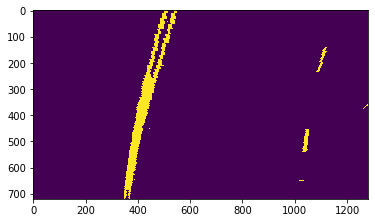

In [26]:
# images = glob.glob("test_images/*.jpg")
# perc_trsf = unwarpTrsf()
# rev_trsf = unwarpTrsf(True)
# for fname in images:
#     img = cv2.imread(fname)
#     undst = cv2.undistort(img, mtx, dist, None, mtx)
#     img_size = img.shape[:2]
#     processed_img = np.zeros_like(undst)
#     processed_img[(hls_select(undst)==1)]=255
#     processed_img = warper(processed_img)
#     processed_img = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)//255*255

#     fit_prev = [None, None]
#     fit_l_r= fit_polynomial(processed_img,fit_prev)
#     plt.imshow(processed_img)
#     left_fit, right_fit = fit_l_r
#     left_ra,  right_ra,offset = measure_curvature_real(left_fit, right_fit,imshape = img.shape[:2])
#     left_fit_ori= polyUnwarp(left_fit, img_size)
#     right_fit_ori = polyUnwarp(right_fit, img_size)
#     processed_img = laneOverlap(undst, left_fit_ori, right_fit_ori)
#     cv2.putText(processed_img,'Radius of Curvature = left: {:.0f}m, right: {:.0f}m'.format(left_ra,right_ra),(50,50), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2, cv2.LINE_AA)
#     cv2.putText(processed_img,'Offset: {:.2f}m'.format(offset),(50,100), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2, cv2.LINE_AA)

#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
#     ax1.imshow(cv2.cvtColor(undst, cv2.COLOR_BGR2RGB))
#     ax1.set_title('undistorted Image', fontsize=30)
#     ax2.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
#     ax2.set_title('result image', fontsize=30)
#     saveFigure(fname, 'result')
#     plt.close()